# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random as rd

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


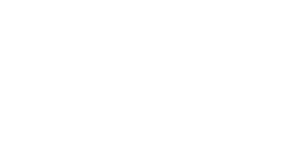

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


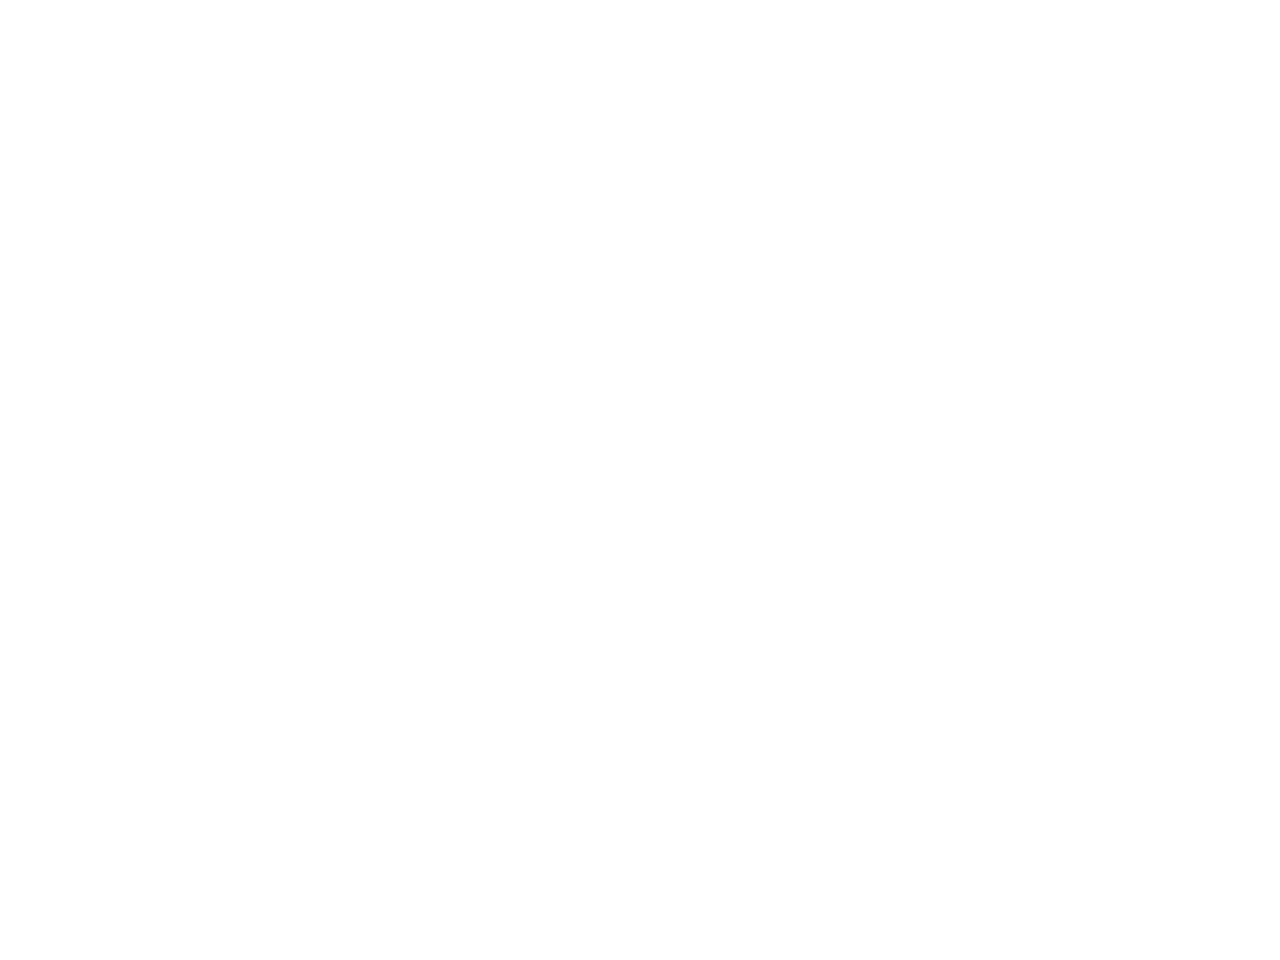

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


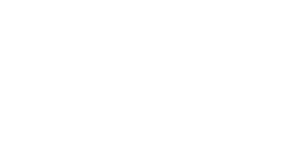

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


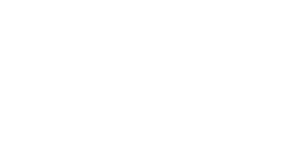

In [6]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


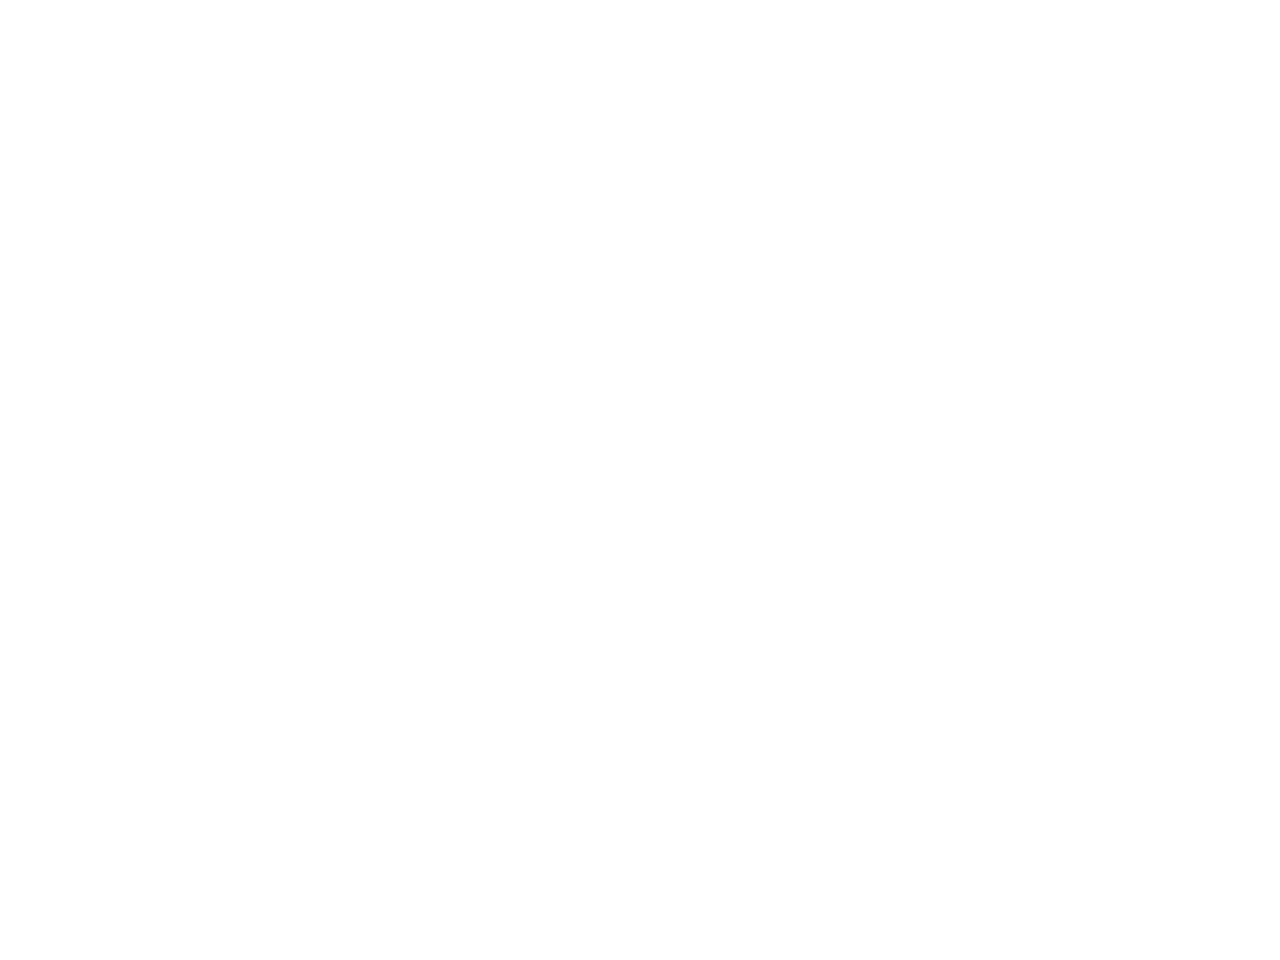

In [7]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [3]:
%matplotlib notebook

# Generowanie zbiorów punktów

In [4]:
def random_set_a(amount, start, end):
    a = np.random.rand(amount) * (start[1] - start[0]) + start[0]
    b = np.random.rand(amount) * (end[1] - end[0]) + end[0]
    return list(zip(a, b))

In [5]:
def random_set_b(amount, center, radius):
    x = np.random.rand(amount) * 2 * np.pi
    a = np.cos(x) * radius + center[0]
    b = np.sin(x) * radius + center[1]
    return list(zip(a, b))

In [6]:
def random_set_c(amount, vertices):
    points = [None]*amount
    for i in range(amount):
        side = rd.choice((1,2,3,4))
        a = rd.uniform(vertices[side - 1][0], vertices[side % 4][0])
        b = rd.uniform(vertices[side - 1][1], vertices[side % 4][1])
        points[i] = (a, b)
    return points

In [7]:
def random_set_d(sides_amount, diagonal_amount, vertices):
    points = []
    left_x, right_x = vertices[0][0], vertices[1][0]
    bottom_y, up_y = vertices[0][1], vertices[3][1]
    
    for point in vertices:
        points.append(point)
        
    for _ in range(sides_amount):        
        horizontal = (rd.uniform(left_x, right_x), 0)
        vertical = (0, rd.uniform(bottom_y, up_y))
        points.append(horizontal)
        points.append(vertical)
        
    for _ in range(diagonal_amount):
        a1 = rd.uniform(vertices[0][0], vertices[1][0])
        a2 = rd.uniform(vertices[3][0], vertices[2][0])
        b1 = a1 + bottom_y
        b2 = -a2 + up_y
        points.append((a1, b1))
        points.append((a2, b2))
        
    return points

In [19]:
set_a = random_set_a(100, [-100, 100], [-100, 100])
set_b = random_set_b(100, [0,0], 10)
set_c = random_set_c(100, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d = random_set_d(25, 20, [[0, 0], [10, 0], [10, 10], [0, 10]])

# Wizualizacja wyników

<IPython.core.display.Javascript object>


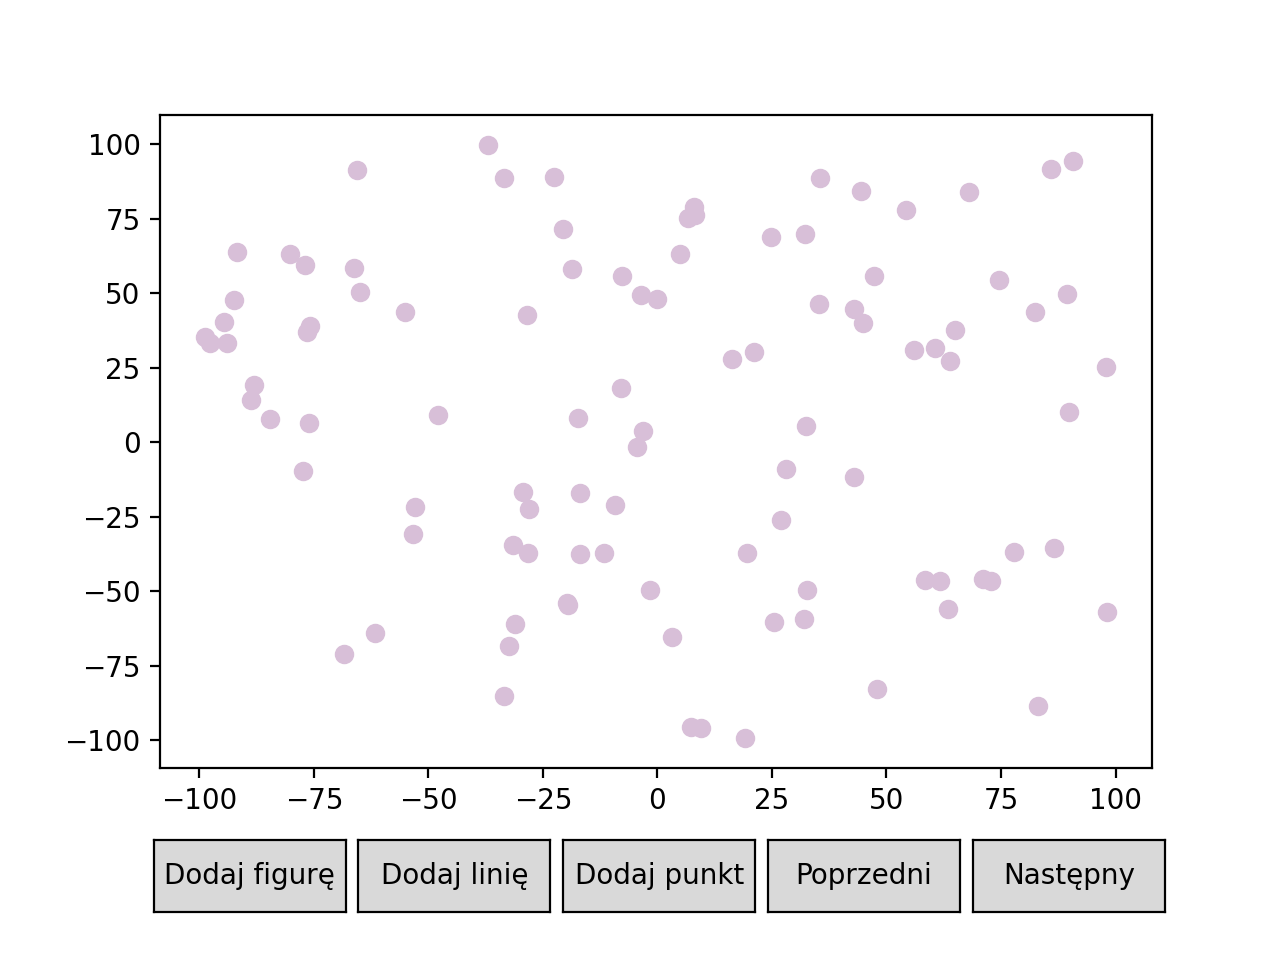

In [15]:
plot = Plot(points=[PointsCollection((set_a), color='thistle')])
plot.draw()

<IPython.core.display.Javascript object>


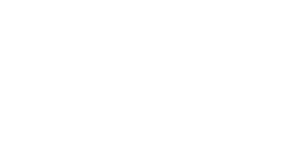

In [16]:
plot = Plot(points=[PointsCollection((set_b), color='thistle')])
plot.draw()

<IPython.core.display.Javascript object>


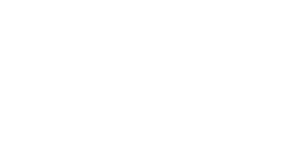

In [17]:
plot = Plot(points=[PointsCollection((set_c), color='thistle')])
plot.draw()

<IPython.core.display.Javascript object>


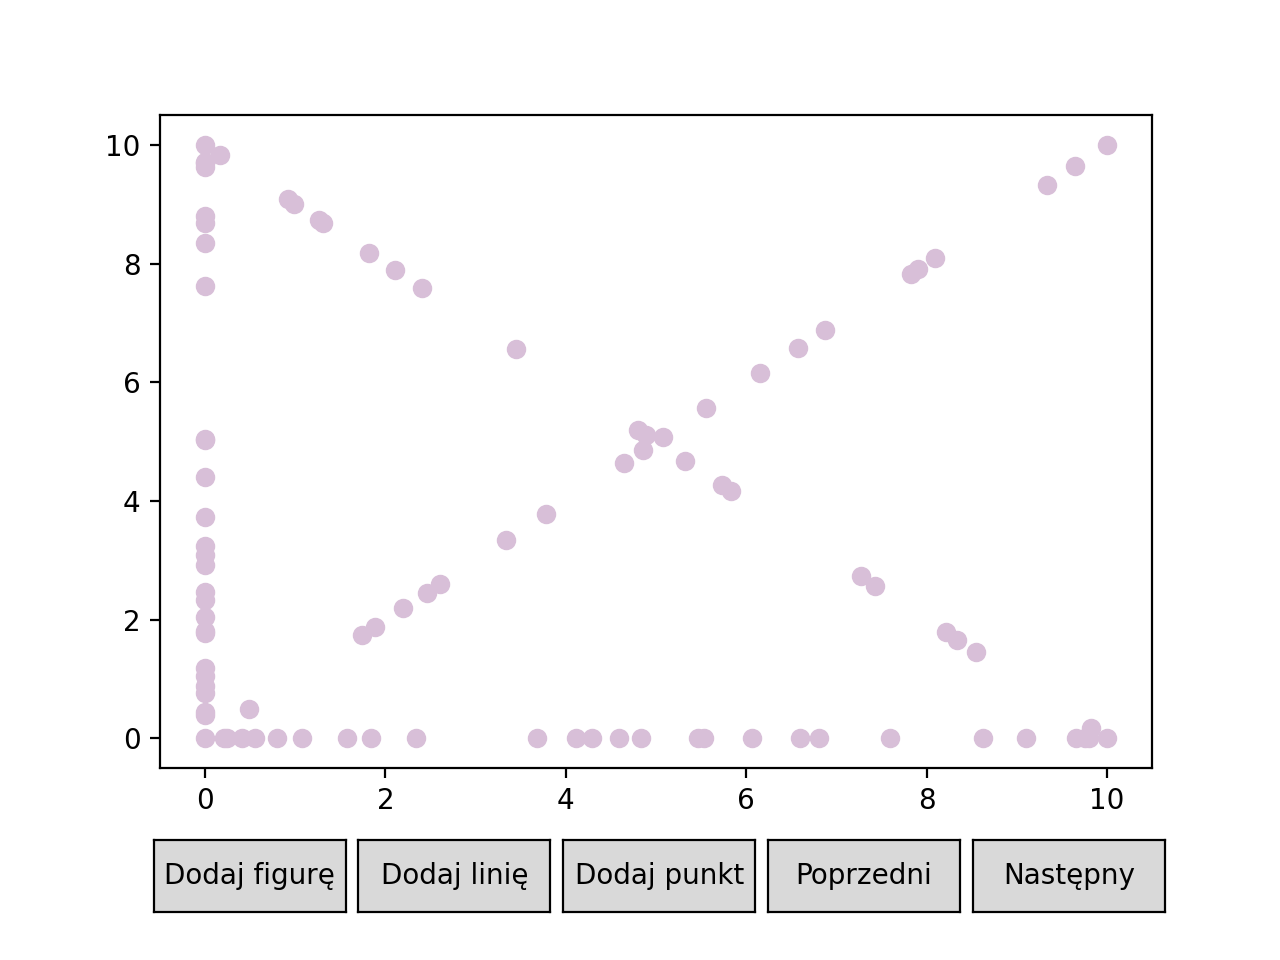

In [18]:
plot = Plot(points=[PointsCollection((set_d), color='thistle')])
plot.draw()

Obliczanie wyznacznika 3x3.

In [8]:
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - c[0] * b[1] - b[0] * a[1] - a[0] * c[1]

Przyjęta tolerancja

In [9]:
Tolerance = 10e-12

Funkcja orient.

In [10]:
def orient(a, b, c):
    determinant = det(a, b, c)
    if determinant > Tolerance:
        return 1
    elif determinant < -Tolerance:
        return -1
    else:
        return 0

# Implementacja algorytmu Grahama

Sortowanie punktów korzystając z algorytmu quicksort.

In [11]:
def dist(a, b):
    return np.sqrt((b[0] - a[0])** 2 + (b[1] - a[1])** 2) # odległość między dwoma punktami

def partition(arr, left, right, elem):
    rand_index = left
    arr[right], arr[rand_index] = arr[rand_index], arr[right]
    i = left
    p = arr[right]
    for j in range(left, right):
        if orient(elem, arr[j], p) == 1 or (orient(elem, arr[j],p) == 0 and dist(elem, arr[j]) > dist(elem, p)):
            arr[i], arr[j] = arr[j], arr[i]
            i += 1
    arr[i], arr[right] = arr[right], arr[i]
    return i

def quicksort(arr, left, right, elem):
    if len(arr) <= 1: 
        return arr
    while left < right:
        pivot = partition(arr, left, right, elem)
        if pivot - left < right - pivot:
            quicksort(arr, left, pivot - 1, elem)
            left = pivot + 1 
        else:
            quicksort(arr, pivot + 1, right, elem)
            right = pivot - 1
    return arr

def quick_sort(arr, elem):
    return quicksort(arr, 0, len(arr) - 1, elem)

Funkcje pomocnicze:

In [12]:
def get_min(points):
    elem = min(points, key = lambda x: (x[1], x[0]))
    idx = points.index(elem)
    return points.pop(idx)

In [13]:
def add_scene(points, s, scenes, i):
    scenes.append(Scene([PointsCollection(points, color = "thistle"),
                                 PointsCollection(s.copy(), color = "hotpink"),
                                PointsCollection([points[i]], color = "cyan")],
                                [LinesCollection([(s[i], s[i + 1]) for i in range(len(s) - 1)], color = "hotpink"),
                                 LinesCollection([(points[i], s[-1])], color = "cyan")]))
    return scenes

In [14]:
def get_lines(s, scenes, points):
    lines = []
    
    for i in range(len(s)-1):
        lines.append([s[i], s[i+1]])
    lines.append([s[-1], s[0]])
    
    scene = Scene([PointsCollection(points, color = "thistle"),PointsCollection(s, color = "hotpink")], [LinesCollection(lines, color = "hotpink")])
    scenes.insert(0,scene)
    
    return scenes

Algorytm Grahama

In [15]:
from copy import copy

def Graham(points_, draw = True):
    points = points_.copy()
    root = get_min(points)
    quick_sort(points, root)
    points.insert(0,root)
    scenes = []
    s = [points[0], points[1], points[2]]
    i = 3
    
    while i < len(points):
        result = orient(s[-2], s[-1], points[i])
        
        if draw:
            scenes = add_scene(points,s,scenes,i)
            
        if result == 1:
            s.append(points[i])
            i += 1
        elif result == 0:
            s.pop()
            s.append(points[i])
            i += 1
        else:
            s.pop()
    
    if orient(s[-2], s[-1], root) == 0: s.pop()   
    if draw: scenes = get_lines(s, scenes,points)
    
    return scenes, s

# Wizualizacje algorytmu Grahama

Liczba punktów należących do otoczki:  11


<IPython.core.display.Javascript object>


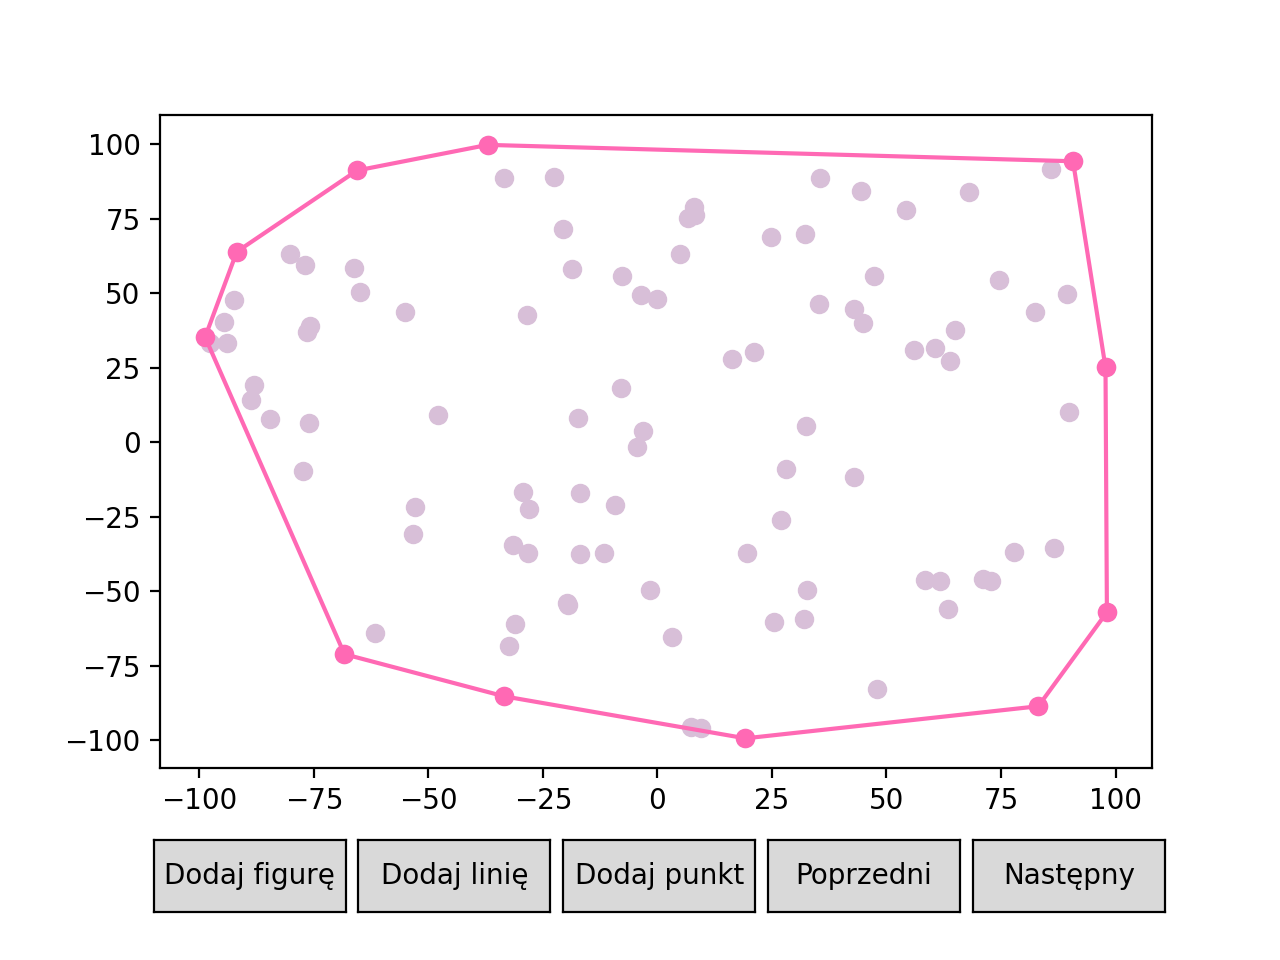

In [27]:
scenes, s = Graham(set_a)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  100


<IPython.core.display.Javascript object>


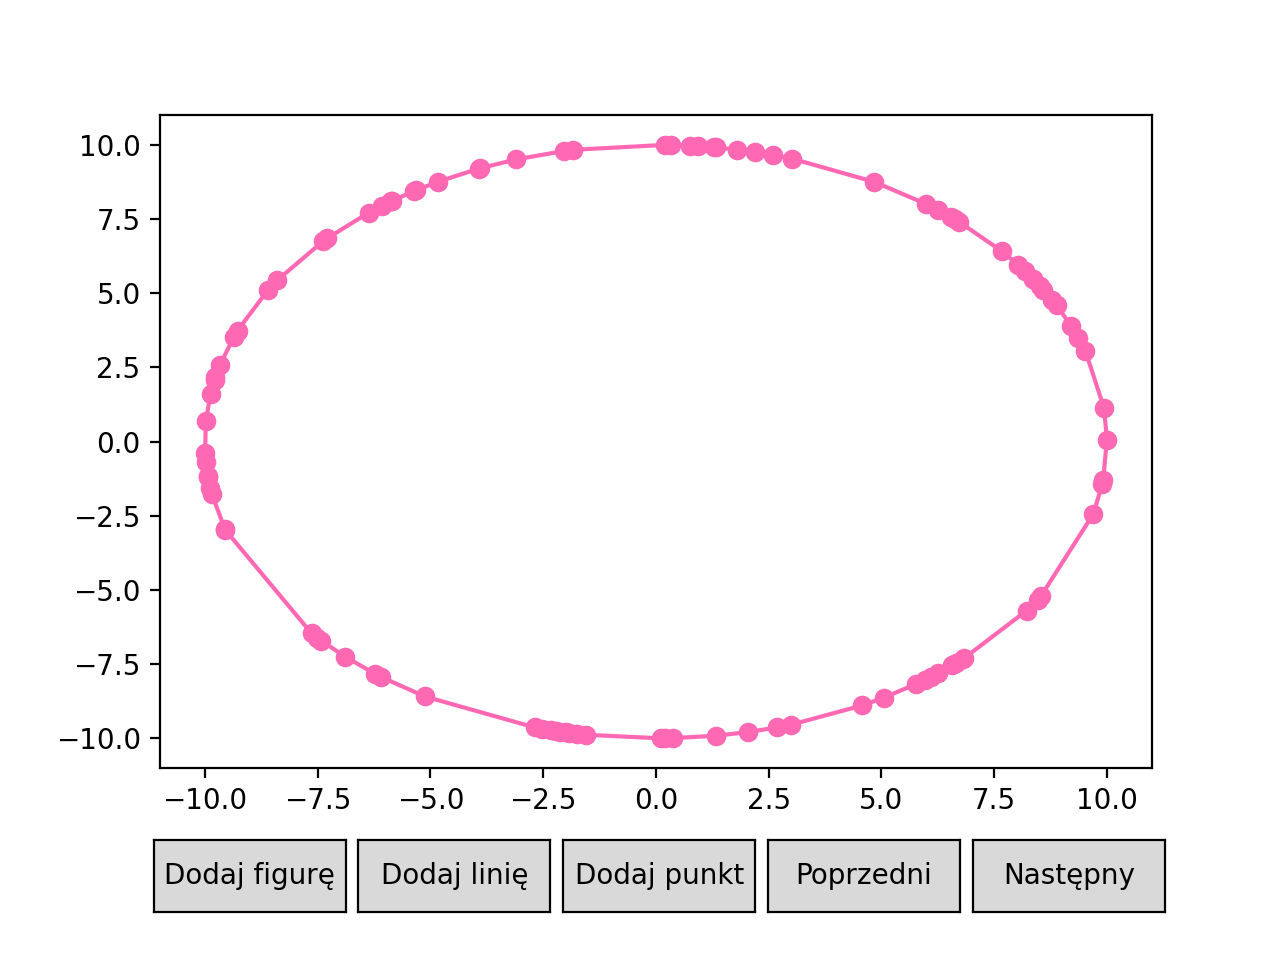

In [28]:
scenes, s = Graham(set_b)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  8


<IPython.core.display.Javascript object>


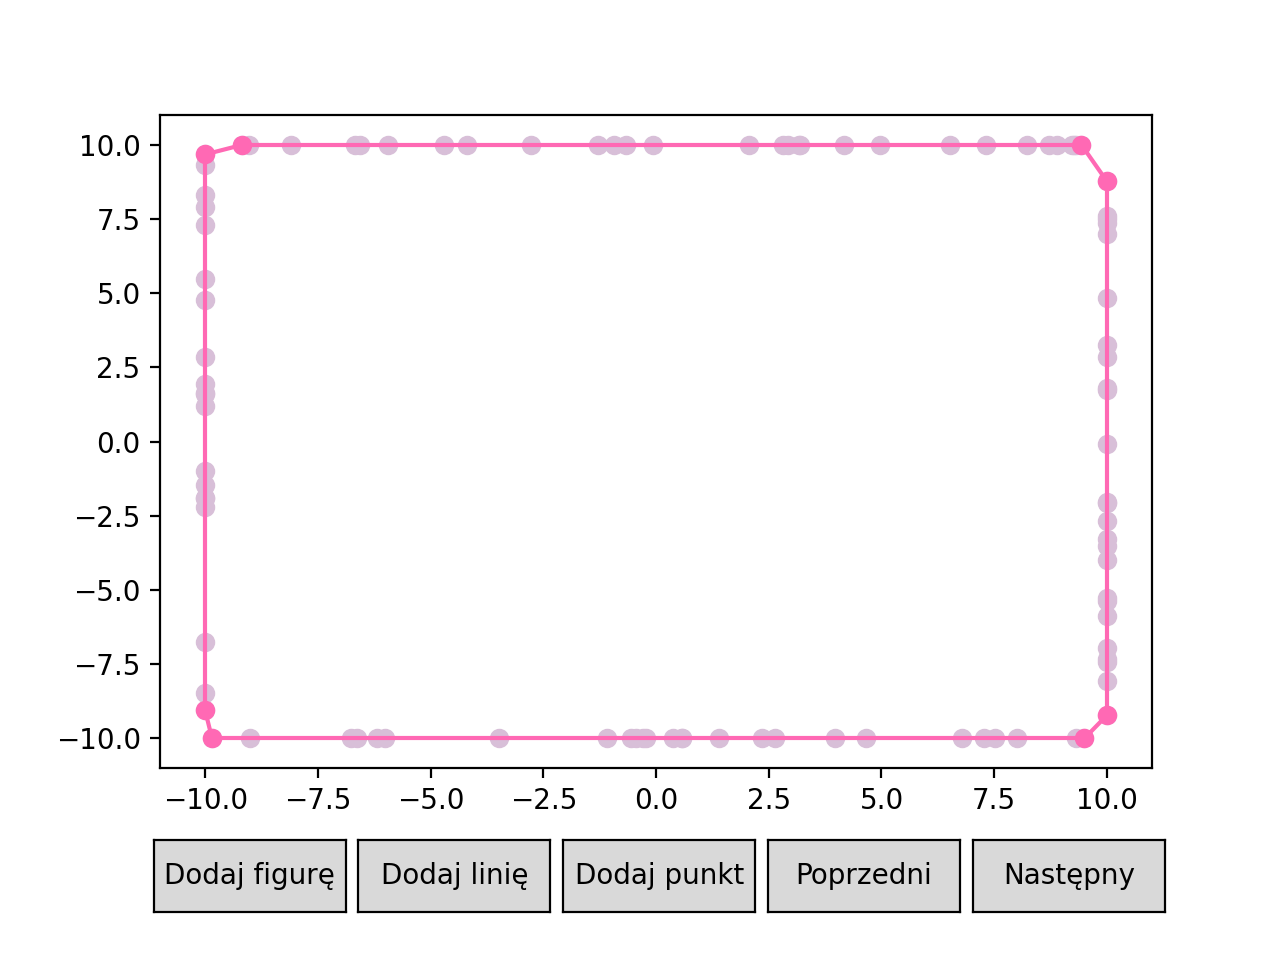

In [29]:
scenes,s = Graham(set_c)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  4


<IPython.core.display.Javascript object>


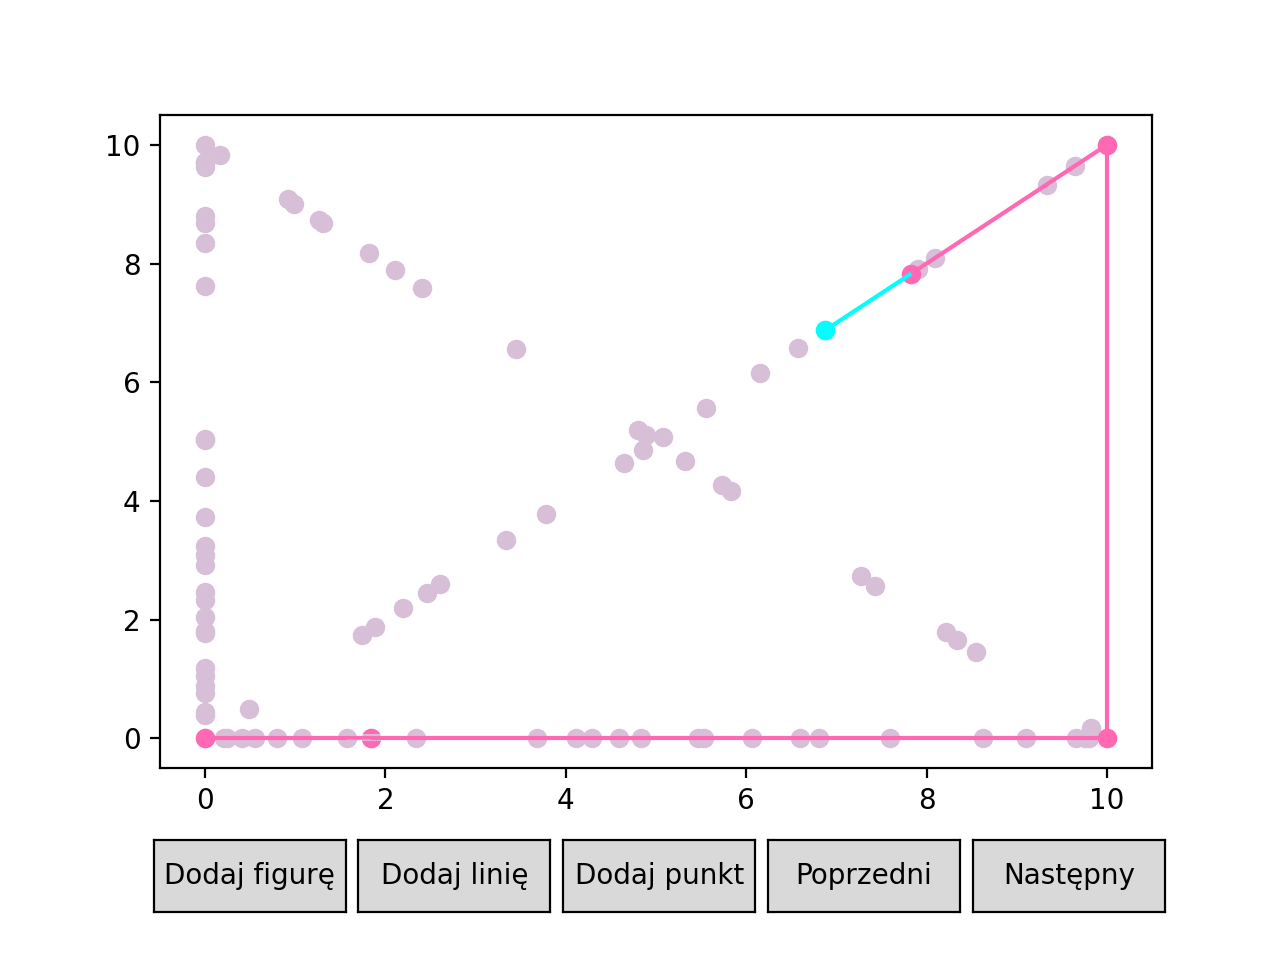

In [30]:
scenes,s = Graham(set_d)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw() 

# Implementacja algorytmu Jarvisa

In [16]:
def Jarvis(points, draw = True):
    elem = min(points, key = lambda x: (x[1], x[0]))
    scenes, s = [], []
    p = elem
    flag = True
    n = len(points)
    
    while p != elem or flag is True:
        flag = False
        point = points[0]
        s.append(p)
        
        for i in range(n):
            if draw: scenes = add_scene(points,s,scenes,i)
            
            if orient(p, point, points[i]) == -1 or (orient(p, points[i], point) == 0 and dist(p, points[i]) > dist(p, point)):
                point = points[i]
    
        p = point
    
    if draw: scenes = get_lines(s, scenes,points)
        
    return scenes,s

# Wizualizacje algorytmu Jarvisa

Liczba punktów należących do otoczki:  11


<IPython.core.display.Javascript object>


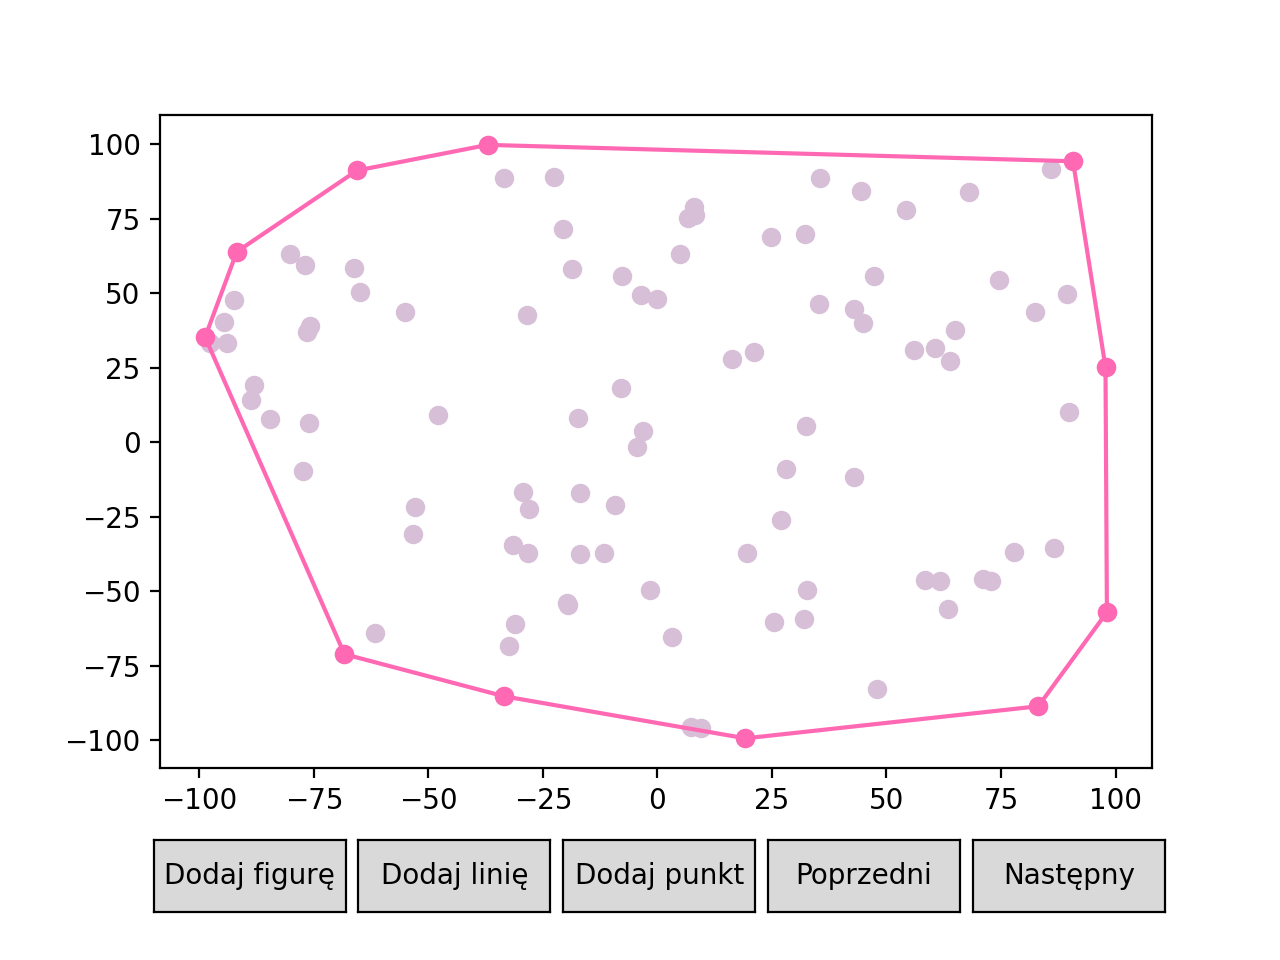

In [32]:
scenes,s = Jarvis(set_a)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  100


<IPython.core.display.Javascript object>


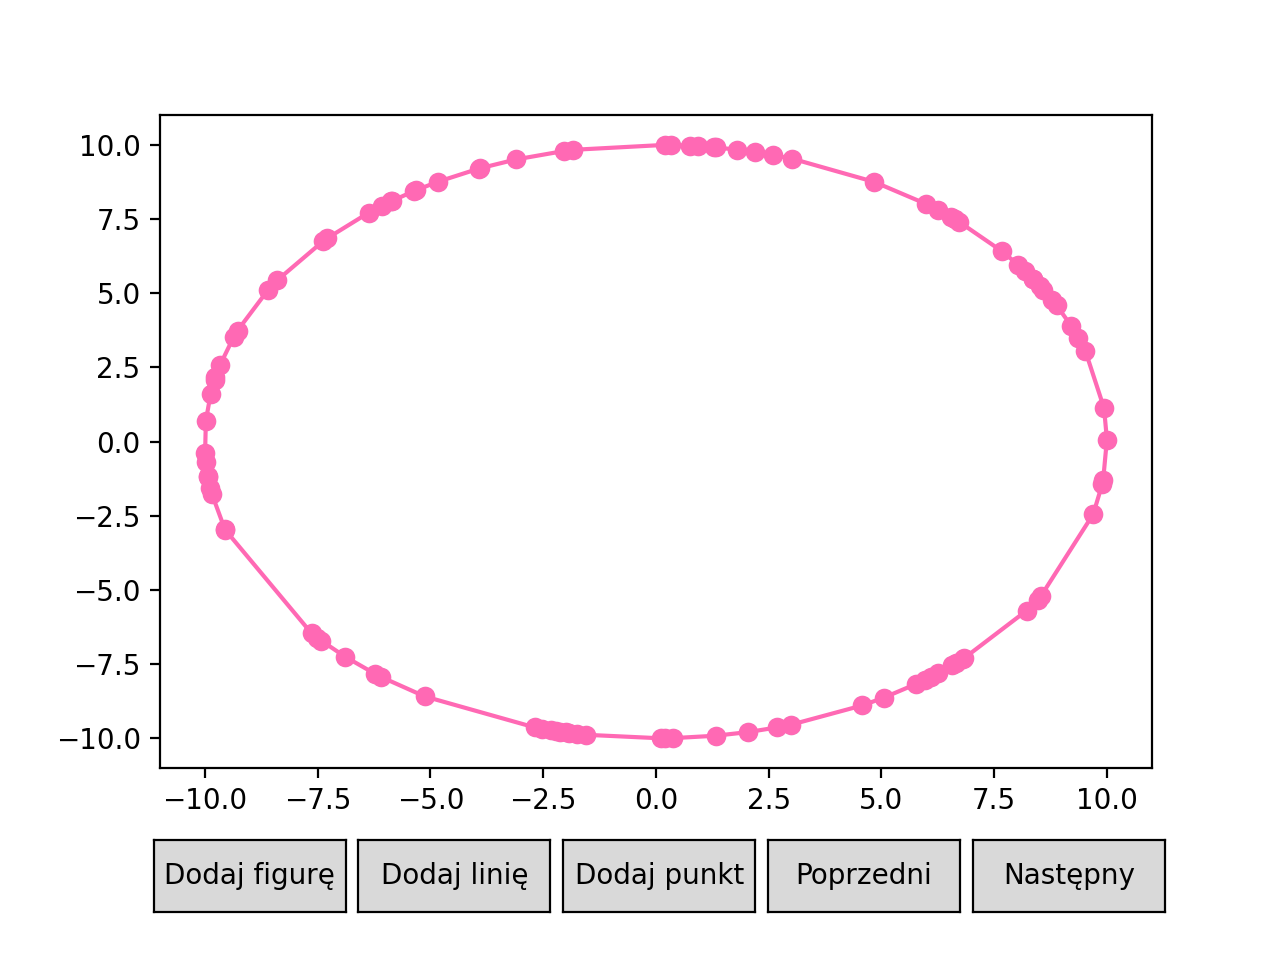

In [33]:
scenes, s = Jarvis(set_b)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  8


<IPython.core.display.Javascript object>


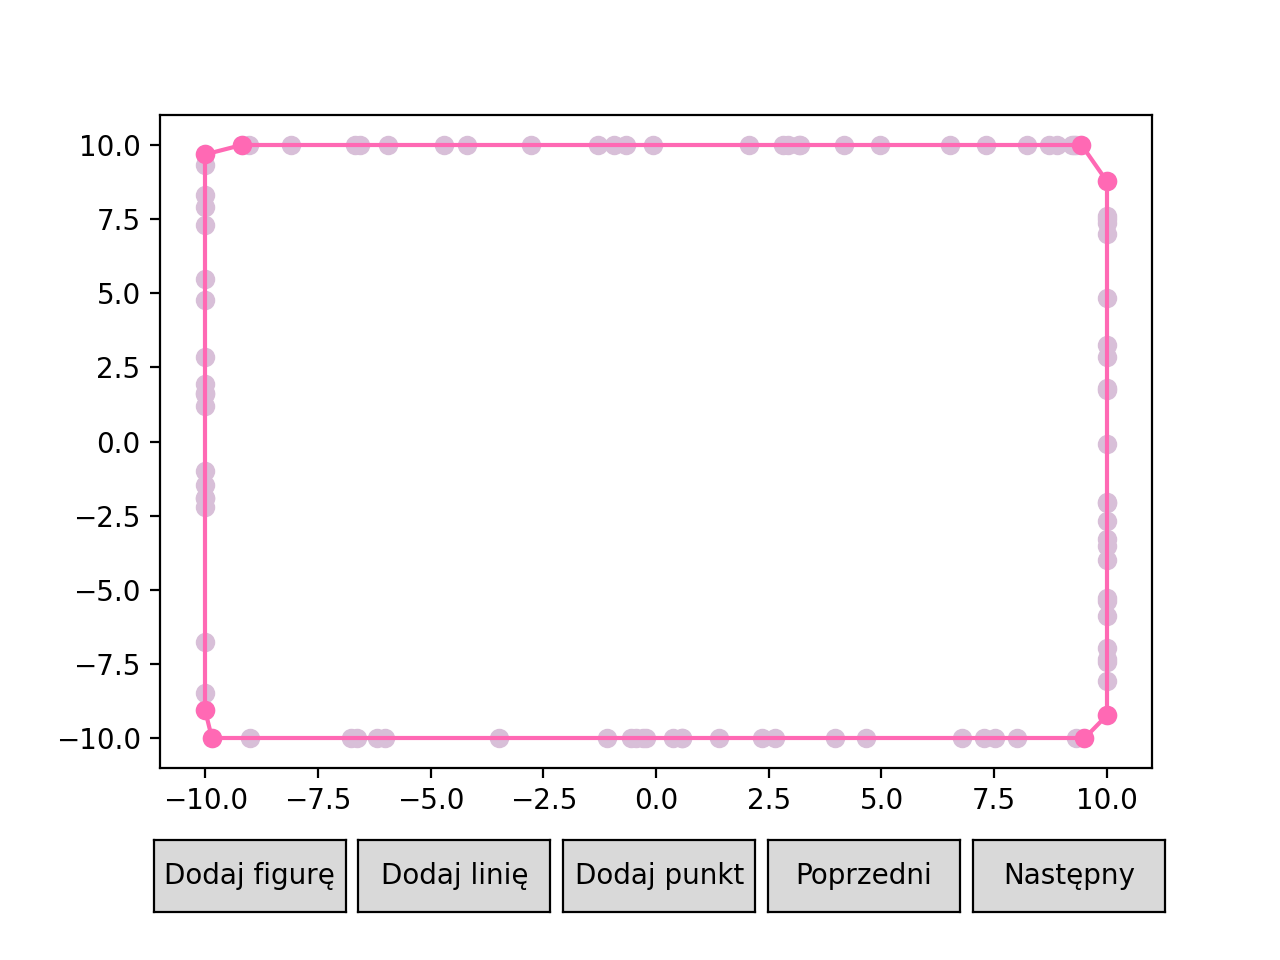

In [34]:
scenes,s = Jarvis(set_c)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

Liczba punktów należących do otoczki:  4


<IPython.core.display.Javascript object>


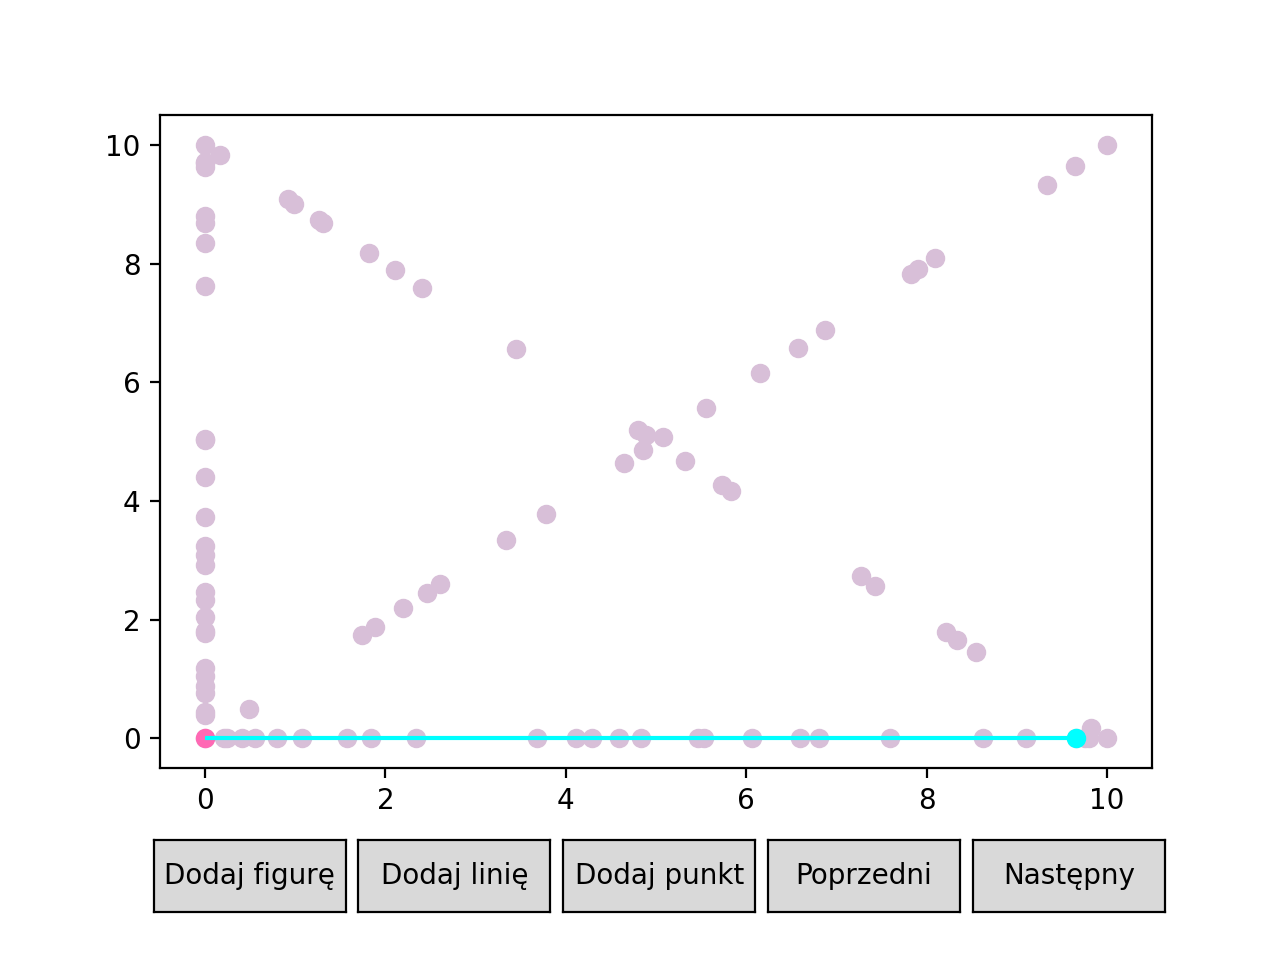

In [35]:
scenes, s = Jarvis(set_d)
print("Liczba punktów należących do otoczki: ", len(s))
plot = Plot(scenes= scenes)
plot.draw()

# Zapisywanie wyników do pliku

In [107]:
def save(hull, number):
    with open('hull_{number}.txt', 'w') as file:
        file.write("\n".join(str(i) for i in hull))

# Czas działania algorytmów dla wszystkich czterech zbiorów

In [17]:
from time import time

def calc_time(points):
    start = time()
    Graham(points, False)
    graham_time = time() - start
    print("czas działania dla algorytmu Grahama to ", graham_time, "sekund")
    start = time()
    Jarvis(points, False)
    jarvis_time = time() - start
    print("czas działania dla algorytmu Jarvisa to ", jarvis_time, "sekund")

In [20]:
calc_time(set_a)

czas działania dla algorytmu Grahama to  0.001439809799194336 sekund
czas działania dla algorytmu Jarvisa to  0.003690004348754883 sekund


In [110]:
calc_time(set_b)

czas działania dla algorytmu Grahama to  0.0023610591888427734 sekund
czas działania dla algorytmu Jarvisa to  0.02783370018005371 sekund


In [112]:
calc_time(set_c)

czas działania dla algorytmu Grahama to  0.0012750625610351562 sekund
czas działania dla algorytmu Jarvisa to  0.0013089179992675781 sekund


In [113]:
calc_time(set_d)

czas działania dla algorytmu Grahama to  0.0035049915313720703 sekund
czas działania dla algorytmu Jarvisa to  0.0015289783477783203 sekund


# Porównanie dla innych zbiorów danych

In [21]:
set_a1 = random_set_a(500, [-100, 100], [-100, 100])
set_b1 = random_set_b(500, [0,0], 10)
set_c1 = random_set_c(500, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d1 = random_set_d(125, 125, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [22]:
calc_time(set_a1)

czas działania dla algorytmu Grahama to  0.015569925308227539 sekund
czas działania dla algorytmu Jarvisa to  0.018026113510131836 sekund


In [23]:
calc_time(set_b1)

czas działania dla algorytmu Grahama to  0.01434016227722168 sekund
czas działania dla algorytmu Jarvisa to  0.5648560523986816 sekund


In [24]:
calc_time(set_c1)

czas działania dla algorytmu Grahama to  0.013313055038452148 sekund
czas działania dla algorytmu Jarvisa to  0.008059024810791016 sekund


In [25]:
calc_time(set_d1)

czas działania dla algorytmu Grahama to  0.024283885955810547 sekund
czas działania dla algorytmu Jarvisa to  0.004642009735107422 sekund


In [26]:
set_a2 = random_set_a(1000, [-100, 100], [-100, 100])
set_b2 = random_set_b(1000, [0,0], 10)
set_c2 = random_set_c(1000, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d2 = random_set_d(250, 250, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [27]:
calc_time(set_a2)

czas działania dla algorytmu Grahama to  0.03008580207824707 sekund
czas działania dla algorytmu Jarvisa to  0.0504300594329834 sekund


In [28]:
calc_time(set_b2)

czas działania dla algorytmu Grahama to  0.029092073440551758 sekund
czas działania dla algorytmu Jarvisa to  2.201598882675171 sekund


In [29]:
calc_time(set_c2)

czas działania dla algorytmu Grahama to  0.022907733917236328 sekund
czas działania dla algorytmu Jarvisa to  0.014140129089355469 sekund


In [30]:
calc_time(set_d2)

czas działania dla algorytmu Grahama to  0.04402589797973633 sekund
czas działania dla algorytmu Jarvisa to  0.00820779800415039 sekund


In [31]:
set_a3 = random_set_a(2000, [-100, 100], [-100, 100])
set_b3 = random_set_b(2000, [0,0], 10)
set_c3 = random_set_c(2000, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d3 = random_set_d(500, 500, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [32]:
calc_time(set_a3)

czas działania dla algorytmu Grahama to  0.0593259334564209 sekund
czas działania dla algorytmu Jarvisa to  0.0789480209350586 sekund


In [33]:
calc_time(set_b3)

czas działania dla algorytmu Grahama to  0.05425095558166504 sekund
czas działania dla algorytmu Jarvisa to  8.989232301712036 sekund


In [34]:
calc_time(set_c3)

czas działania dla algorytmu Grahama to  0.052214860916137695 sekund
czas działania dla algorytmu Jarvisa to  0.025950908660888672 sekund


In [35]:
calc_time(set_d3)

czas działania dla algorytmu Grahama to  0.09234809875488281 sekund
czas działania dla algorytmu Jarvisa to  0.016463279724121094 sekund


In [36]:
set_a4 = random_set_a(3000, [-100, 100], [-100, 100])
set_b4 = random_set_b(3000, [0,0], 10)
set_c4 = random_set_c(3000, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d4 = random_set_d(750, 750, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [37]:
calc_time(set_a4)

czas działania dla algorytmu Grahama to  0.08963608741760254 sekund
czas działania dla algorytmu Jarvisa to  0.1392822265625 sekund


In [38]:
calc_time(set_b4)

czas działania dla algorytmu Grahama to  0.09686899185180664 sekund
czas działania dla algorytmu Jarvisa to  19.043423891067505 sekund


In [39]:
calc_time(set_c4)

czas działania dla algorytmu Grahama to  0.07152628898620605 sekund
czas działania dla algorytmu Jarvisa to  0.039366960525512695 sekund


In [40]:
calc_time(set_d4)

czas działania dla algorytmu Grahama to  0.14596199989318848 sekund
czas działania dla algorytmu Jarvisa to  0.024959087371826172 sekund


In [41]:
set_a5 = random_set_a(4000, [-100, 100], [-100, 100])
set_b5 = random_set_b(4000, [0,0], 10)
set_c5 = random_set_c(4000, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d5 = random_set_d(1000, 1000, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [42]:
calc_time(set_a5)

czas działania dla algorytmu Grahama to  0.11691021919250488 sekund
czas działania dla algorytmu Jarvisa to  0.19142889976501465 sekund


In [44]:
calc_time(set_b5)

czas działania dla algorytmu Grahama to  0.11602210998535156 sekund
czas działania dla algorytmu Jarvisa to  34.37821102142334 sekund


In [45]:
calc_time(set_c5)

czas działania dla algorytmu Grahama to  0.0992131233215332 sekund
czas działania dla algorytmu Jarvisa to  0.0524599552154541 sekund


In [46]:
calc_time(set_d5)

czas działania dla algorytmu Grahama to  0.19083690643310547 sekund
czas działania dla algorytmu Jarvisa to  0.032610177993774414 sekund


In [47]:
set_a6 = random_set_a(5000, [-100, 100], [-100, 100])
set_b6 = random_set_b(5000, [0,0], 10)
set_c6 = random_set_c(5000, [[-10, 10], [-10, -10], [10, -10], [10, 10]])
set_d6 = random_set_d(1250, 1250, [[0, 0], [10, 0], [10, 10], [0, 10]])

In [48]:
calc_time(set_a6)

czas działania dla algorytmu Grahama to  0.14859485626220703 sekund
czas działania dla algorytmu Jarvisa to  0.2415602207183838 sekund


In [49]:
calc_time(set_b6)

czas działania dla algorytmu Grahama to  0.14101409912109375 sekund
czas działania dla algorytmu Jarvisa to  55.94336819648743 sekund


In [50]:
calc_time(set_c6)

czas działania dla algorytmu Grahama to  0.12274980545043945 sekund
czas działania dla algorytmu Jarvisa to  0.0653219223022461 sekund


In [51]:
calc_time(set_d6)

czas działania dla algorytmu Grahama to  0.2543210983276367 sekund
czas działania dla algorytmu Jarvisa to  0.04054880142211914 sekund


# Algorytmy bez flag - testowanie czasu

W algorytmach usunięto flagi, które oznaczały, czy dany zbiór ma zostać zwizualizowany. Przeprowadzono 

In [52]:
from copy import copy

def Graham_without_flag(points_):
    points = points_.copy()
    root = get_min(points)
    quick_sort(points, root)
    points.insert(0,root)
    s = [points[0], points[1], points[2]]
    i = 3
    
    while i < len(points):
        result = orient(s[-2], s[-1], points[i])
    
        if result == 1:
            s.append(points[i])
            i += 1
        elif result == 0:
            s.pop()
            s.append(points[i])
            i += 1
        else:
            s.pop()
    
    if orient(s[-2], s[-1], root) == 0: s.pop()   
    
    return s

In [53]:
def Jarvis_without_flag(points):
    elem = min(points, key = lambda x: (x[1], x[0]))
    s =  []
    p = elem
    flag = True
    n = len(points)
    
    while p != elem or flag is True:
        flag = False
        point = points[0]
        s.append(p)
        
        for i in range(n):
        
            if orient(p, point, points[i]) == -1 or (orient(p, points[i], point) == 0 and dist(p, points[i]) > dist(p, point)):
                point = points[i]
    
        p = point
        
    return s

In [54]:
from time import time

def calc(points):
    start = time()
    Graham_without_flag(points)
    graham_time = time() - start
    print("czas działania dla algorytmu Grahama to ", graham_time, "sekund")
    start = time()
    Jarvis_without_flag(points)
    jarvis_time = time() - start
    print("czas działania dla algorytmu Jarvisa to ", jarvis_time, "sekund")

In [55]:
calc(set_a1)

czas działania dla algorytmu Grahama to  0.015356063842773438 sekund
czas działania dla algorytmu Jarvisa to  0.01792311668395996 sekund


In [56]:
calc(set_b1)

czas działania dla algorytmu Grahama to  0.014191150665283203 sekund
czas działania dla algorytmu Jarvisa to  0.556588888168335 sekund


In [57]:
calc(set_c1)

czas działania dla algorytmu Grahama to  0.013500213623046875 sekund
czas działania dla algorytmu Jarvisa to  0.007842063903808594 sekund


In [58]:
calc(set_d1)

czas działania dla algorytmu Grahama to  0.023842811584472656 sekund
czas działania dla algorytmu Jarvisa to  0.0044019222259521484 sekund


In [59]:
calc(set_a2)

czas działania dla algorytmu Grahama to  0.029766082763671875 sekund
czas działania dla algorytmu Jarvisa to  0.05017399787902832 sekund


In [60]:
calc(set_b2)

czas działania dla algorytmu Grahama to  0.02965402603149414 sekund
czas działania dla algorytmu Jarvisa to  2.1479060649871826 sekund


In [61]:
calc(set_c2)

czas działania dla algorytmu Grahama to  0.02485489845275879 sekund
czas działania dla algorytmu Jarvisa to  0.013477802276611328 sekund


In [62]:
calc(set_d2)

czas działania dla algorytmu Grahama to  0.03654193878173828 sekund
czas działania dla algorytmu Jarvisa to  0.00815725326538086 sekund


In [63]:
calc(set_a3)

czas działania dla algorytmu Grahama to  0.05929112434387207 sekund
czas działania dla algorytmu Jarvisa to  0.07729172706604004 sekund


In [64]:
calc(set_b3)

czas działania dla algorytmu Grahama to  0.05325007438659668 sekund
czas działania dla algorytmu Jarvisa to  8.768624305725098 sekund


In [65]:
calc(set_c3)

czas działania dla algorytmu Grahama to  0.05223393440246582 sekund
czas działania dla algorytmu Jarvisa to  0.026077985763549805 sekund


In [66]:
calc(set_d3)

czas działania dla algorytmu Grahama to  0.09070801734924316 sekund
czas działania dla algorytmu Jarvisa to  0.016094207763671875 sekund


In [67]:
calc(set_a4)

czas działania dla algorytmu Grahama to  0.08754491806030273 sekund
czas działania dla algorytmu Jarvisa to  0.13471102714538574 sekund


In [68]:
calc(set_b4)

czas działania dla algorytmu Grahama to  0.09596920013427734 sekund
czas działania dla algorytmu Jarvisa to  19.577105045318604 sekund


In [69]:
calc(set_c4)

czas działania dla algorytmu Grahama to  0.07105565071105957 sekund
czas działania dla algorytmu Jarvisa to  0.039031028747558594 sekund


In [70]:
calc(set_d4)

czas działania dla algorytmu Grahama to  0.14478325843811035 sekund
czas działania dla algorytmu Jarvisa to  0.024229049682617188 sekund


In [71]:
calc(set_a5)

czas działania dla algorytmu Grahama to  0.11629700660705566 sekund
czas działania dla algorytmu Jarvisa to  0.18599200248718262 sekund


In [72]:
calc(set_b5)

czas działania dla algorytmu Grahama to  0.11714506149291992 sekund
czas działania dla algorytmu Jarvisa to  34.61221623420715 sekund


In [73]:
calc(set_c5)

czas działania dla algorytmu Grahama to  0.09887003898620605 sekund
czas działania dla algorytmu Jarvisa to  0.051714181900024414 sekund


In [74]:
calc(set_d5)

czas działania dla algorytmu Grahama to  0.19052791595458984 sekund
czas działania dla algorytmu Jarvisa to  0.03275799751281738 sekund


In [75]:
calc(set_a6)

czas działania dla algorytmu Grahama to  0.14532089233398438 sekund
czas działania dla algorytmu Jarvisa to  0.23801207542419434 sekund


In [76]:
calc(set_b6)

czas działania dla algorytmu Grahama to  0.13940000534057617 sekund
czas działania dla algorytmu Jarvisa to  55.816141843795776 sekund


In [77]:
calc(set_c6)

czas działania dla algorytmu Grahama to  0.12503910064697266 sekund
czas działania dla algorytmu Jarvisa to  0.06617379188537598 sekund


In [78]:
calc(set_d6)

czas działania dla algorytmu Grahama to  0.2665109634399414 sekund
czas działania dla algorytmu Jarvisa to  0.04293012619018555 sekund
